# Travail 1

### Dans le cadre du cours IFT3700 - Science des données

Effectué par <br> Alexandre Chartrand,<br> Lauranne Deaudelin, <br> Amélie Lacombe Robillard, et <br> Stéphane Verville-Vohl

## Libraires à installer 
Il faut s'arrurer que la librairie pyclustering est installée.  
https://pypi.org/project/pyclustering/0.8.0/  

Vous n'avez qu'à décommenter pour installer la librairie

In [2]:
#!pip install pyclustering

## Import libraries

In [3]:
import numpy as np
import pylab
import matplotlib.pyplot as plt
import csv

%matplotlib inline

## Import data

In [4]:
TRAINING_SIZE = 50
TEST_SIZE = 25

def extract_data(dataset, size):
    data = open(dataset)
    reader = csv.reader(data)
    data_points = []
    count = 0
    for row in reader:
        if count == 0:
            count += 1
            continue
        elif count <= size:
            data_points.append(row)
            count += 1
        else:
            break
    data.close()

    # Convert data in numpy array, with int type
    ndarray_dataset = np.array(data_points).astype(int)
    
    # Data input
    inputs = ndarray_dataset[:,1:]
    # Target vector (label vector)
    targets = ndarray_dataset[:,0]
    
    return (inputs, targets)

training_data = extract_data('mnist_train.csv', TRAINING_SIZE)
training_inputs = training_data[0]
training_targets = training_data[1]

test_data = extract_data('mnist_test.csv', TEST_SIZE)
test_inputs = test_data[0]
test_targets = test_data[1]

## Custom Similarity Measure

In [5]:
def custom_similarity_measure(x,y):
    return min_translation_distance(x,y)
    #return np.sum(abs(x-y))

In [6]:
from scipy.spatial import distance as dist
#### Helper functions ######

# Crop a matrix according to margins of format (top, bottom, left, right)
def crop_matrix(x, margins):
    return x[margins[0]:x.shape[0]-margins[1],margins[2]:x.shape[1]-margins[3]]

# Pad a matrix with zeros according to a margin of format (top, bottom, left, right)
def pad_matrix(x, margins):
    x_tilda = np.zeros((x.shape[0]+margins[0]+margins[1], x.shape[1]+margins[2]+margins[3]), dtype=int)
    for i in range(0, x.shape[0]):
        for j in range(0, x.shape[1]) :
            x_tilda[i+margins[0],j+margins[2]] = x[i,j]
    return x_tilda

##### Custom similarity measure based on smallest translation distance
# Return the smallest distance of possible translations along the vertical and horizontal axis
# for a translation of d pixels or smaller
# This measure is symetric as the same translations are applied to X and Y
def min_translation_distance(x, y, d=1):
    
    transform_margins = []
    for i in range(1, d+1) :
        transform_margins.extend([[0, d, i, d-i], # horizontal translation
                                  [i, d-i, 0, d]]) # vertical translation
    
    #We assume that we are working with mnist data, or else reshaping dimensions are not valid
    if (x.size != 784) or (x.size != y.size) :
        print("invalid x or y")

    #Test without translation : 
    smallest_dist = dist.correlation(x, y)
    
    # We pad the matrices by the distance of the translation we want to apply
    # This ensure that we will always be comparing same size matrices
    # and won't impact the overall distance (as MNIST numbers are already surrounded by white pixels)
    x_padded = pad_matrix(x.reshape(28,28), [0,d,0,d])
    y_padded = pad_matrix(y.reshape(28,28), [0,d,0,d])

    #Apply translations to the x matrix and test resulting distance
    for i in range(0, len(transform_margins)) :
        distance = dist.correlation(crop_matrix(x_padded, transform_margins[i]).reshape(1,784), y.reshape(1,784))
        if(distance < smallest_dist) :
            smallest_dist = distance
            
    #Apply translations to the y matrix and test resulting distancee
    for i in range(0, len(transform_margins)) :
        distance = dist.correlation(x.reshape(1, 784), crop_matrix(y_padded, transform_margins[i]).reshape(1,784))
        if(distance < smallest_dist) :
            smallest_dist = distance
    
    # Return the smallest (optimal) distance found
    return smallest_dist


## Euclidean Distance

In [7]:
def euclidean_similarity_measure(x, y):
    return np.sqrt(np.dot(x,x) - 2 * np.dot(x,y) + np.dot(y,y))

## Dissimilarity Matrix with the custom measure

In [8]:
def generate_distance_matrix(data, distance_type):
    nb_examples = data.shape[0]
    distance_ndarray = np.zeros((nb_examples,nb_examples))
    
    for i in range(nb_examples):
        j=0
        while j != i:
            if distance_type is 'euclidean':
                euc_sim_measure = euclidean_similarity_measure(data[i],data[j])
                distance_ndarray[i][j] = euc_sim_measure
                distance_ndarray[j][i] = euc_sim_measure
                
            elif distance_type is 'custom':
                custom_sim_measure = custom_similarity_measure(data[i],data[j])
                distance_ndarray[i][j] = custom_sim_measure
                distance_ndarray[j][i] = custom_sim_measure
            else:
                print("accepted values for argument 'distance_type': 'euclidean','custom'")
                return
            j += 1
    return distance_ndarray

## Compute dissimilarity matrices on the data

In [9]:
custom_distance_matrix = generate_distance_matrix(training_inputs, 'custom')
euclidean_distance_matrix = generate_distance_matrix(training_inputs, 'euclidean')

## K-medoid Algorithm

In [10]:
from sklearn import metrics
from pyclustering.cluster.kmedoids import kmedoids

K = 10

# Initialization of medoids
initial_medoids = [i for i in range(K)]

def map_medoid_labels(medoids):
    medoid_labels = []
    for i,medoid in enumerate(medoids):
        medoid_labels.append((i, training_targets[medoid]))
    return medoid_labels
    
    
def kmedoid_predict(medoids, distance_type):
    predictions = []
    # For all test inputs
    for row in test_inputs:
        min_arg = (404, float('inf'))
        for medoid in medoids:
            # Find the closest medoid
            if distance_type is 'euclidean':
                candidate_distance = euclidean_similarity_measure(row, training_inputs[medoid])
            elif distance_type is 'custom':
                candidate_distance = custom_similarity_measure(row, training_inputs[medoid])
            if candidate_distance < min_arg[1]:
                min_arg = (medoid, candidate_distance)
        # Return the nearest medoid's label
        predictions.append(training_targets[min_arg[0]])
        ndarray_predictions = np.array(predictions).astype(int)
    return ndarray_predictions


def kmedoid_prediction_score(predictions):
    error = 0
    for i, prediction in enumerate(predictions):
        target = test_targets[i]
        if prediction != target:
            error += 1
    return 1 - error/predictions.shape[0]


# ================ Euclidean k-Medoid ======================
euclidean_kmedoids = kmedoids(euclidean_distance_matrix, initial_medoids, data_type='distance_matrix')
euclidean_kmedoids.process()
euclidean_clusters = euclidean_kmedoids.get_clusters()
euclidean_medoids = euclidean_kmedoids.get_medoids()
euclidean_predictions = kmedoid_predict(euclidean_medoids, 'euclidean')
euclidean_kmedoid_score = kmedoid_prediction_score(euclidean_predictions)

print('\nEuclidean distance results:')
print("\nTraining dataset size:", TRAINING_SIZE)
print("\nNumber of medoids:", K)
print("Cluster mapping:", map_medoid_labels(euclidean_medoids))
print("Euclidean prediction score:", euclidean_kmedoid_score)
print("Euclidean adjusted Rand Score:",  metrics.adjusted_rand_score(test_targets, euclidean_predictions))
print("Euclidean homogeneity:", metrics.homogeneity_score(test_targets, euclidean_predictions))
print("Euclidean cluster completeness:", metrics.completeness_score(test_targets, euclidean_predictions))

                             
# ==================== Custom k-Medoid =====================
custom_kmedoids = kmedoids(custom_distance_matrix, initial_medoids, data_type='distance_matrix')
custom_kmedoids.process()
custom_clusters = custom_kmedoids.get_clusters()
custom_medoids = custom_kmedoids.get_medoids()                             
custom_predictions = kmedoid_predict(custom_medoids, 'custom')
custom_kmedoid_score = kmedoid_prediction_score(custom_predictions)

print('\nCustom distance results:')
print("\nTraining dataset size:", TRAINING_SIZE)
print("\nNumber of medoids:", K)
print("Cluster mapping:", map_medoid_labels(custom_medoids))
print("Custom prediction score:", custom_kmedoid_score)
print("Custom adjusted Rand score:",  metrics.adjusted_rand_score(test_targets, custom_predictions))
print("Custom homogeneity:", metrics.homogeneity_score(test_targets, custom_predictions))
print("Custom cluster completeness:", metrics.completeness_score(test_targets, custom_predictions))



Euclidean distance results:

Training dataset size: 50

Number of medoids: 10
Cluster mapping: [(0, 3), (1, 0), (2, 4), (3, 1), (4, 9), (5, 2), (6, 1), (7, 3), (8, 1), (9, 9)]
Euclidean prediction score: 0.48
Euclidean adjusted Rand Score: 0.15305505142165757
Euclidean homogeneity: 0.4262560142614984
Euclidean cluster completeness: 0.6802679496472186

Custom distance results:

Training dataset size: 50

Number of medoids: 10
Cluster mapping: [(0, 5), (1, 0), (2, 4), (3, 1), (4, 9), (5, 2), (6, 6), (7, 3), (8, 1), (9, 4)]
Custom prediction score: 0.6
Custom adjusted Rand score: 0.3674549363320655
Custom homogeneity: 0.6328272321194643
Custom cluster completeness: 0.8161953447518968


## Binary partition Algorithm

In [11]:
from sklearn.cluster import AgglomerativeClustering as Agg

euclidean_partition__builtin = Agg(10, 'euclidean', None, None, 'auto','average')
euclidean_partition__builtin.fit(training_inputs)

euclidean_partition_euclid = Agg(10,'precomputed', None, None, 'auto', 'average')
euclidean_partition_euclid.fit(euclidean_distance_matrix)

custom_partition = Agg(10, 'precomputed', None, None, 'auto', 'average')
custom_partition.fit(custom_distance_matrix)

Eu_b_score = metrics.silhouette_score(training_inputs, euclidean_partition__builtin.labels_, 'euclidean')
Eu_c_score = metrics.silhouette_score(euclidean_distance_matrix, euclidean_partition_euclid.labels_, 'precomputed')
Cu_score = metrics.silhouette_score(custom_distance_matrix,custom_partition.labels_, metric='precomputed')

print('Euclidean build in silhouette score:', Eu_b_score)
print('Euclidean custom silhouette score:', Eu_c_score)
print('Custom silhouette score:', Cu_score)


Euclidean build in silhouette score: 0.09919217984639267
Euclidean custom silhouette score: 0.09919217984639267
Custom silhouette score: 0.1969254895607735


## PCoA  Algorithm

In [12]:
from sklearn.manifold import MDS

#PCOA avec matrice de dissimilarité euclidienne
pcoa_euclid = MDS(n_components=2, dissimilarity='precomputed')
euclid_transformed = pcoa_euclid.fit_transform(euclidean_distance_matrix)

#PCOA avec matrice de dissimilarité custom
pcoa_custom = MDS(n_components=2, dissimilarity='precomputed')
custom_transformed = pcoa_custom.fit_transform(custom_distance_matrix)

Légende
0  :  blue
1  :  red
2  :  green
3  :  yellow
4  :  cyan
5  :  black
6  :  darkorange
7  :  lightcoral
8  :  lime
9  :  grey


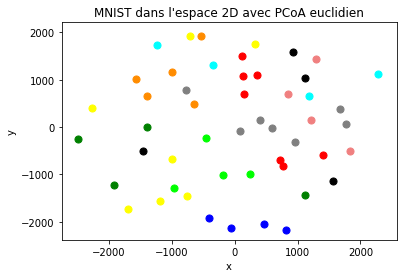

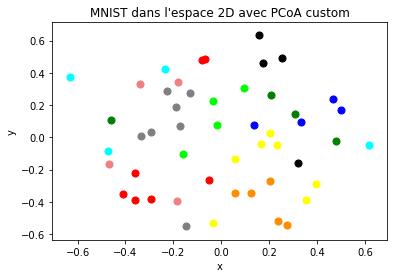

Goodness-of-Fit for PCoA with eucliedian distance:       0.24045270562536641
Goodness-of-Fit for PCoA with custom similarity mesure:  0.21426427751294727

Best goodness-of-Fit:  PCoA with custom similarity mesure


In [13]:
colors = ['blue', 'red', 'green', 'yellow', 'cyan', 'black', 'darkorange', 'lightcoral', 'lime', 'grey']

def extract_data_by_label(inputs, targets, label) :
    return(inputs[np.where(targets[:] == label)[0], :])
    
def plot_graph_by_labels(inputs, targets, title, colors) :
    for i in range(0, 10) :
            extracted = extract_data_by_label(inputs, targets, i)
            plt.scatter(extracted[:,0], extracted[:,1], 50, colors[i])
    pylab.xlabel('x')
    pylab.ylabel('y')
    plt.title(title)
    plt.show()
    
print('Légende')
for i in range(0, len(colors)) :
    print(i, ' : ', colors[i])
    
plot_graph_by_labels(euclid_transformed, training_targets, 'MNIST dans l\'espace 2D avec PCoA euclidien', colors)
plot_graph_by_labels(custom_transformed, training_targets, 'MNIST dans l\'espace 2D avec PCoA custom', colors)

# Mesures de performance utilisée :  
# Nous utilisons la racine de l'erreur de moindre carrée (différence entre la distance de la matrice de dissimilarité et de la distance 
# prédite par le modèle MDS, divisée par la somme au carrée des distances de la matrice de dissimilarité)
# Cette valeur représente le stress, qui permet de quantifer si le modèle fitent avec les données. 
# Plus la valeur est proche de 0, plus le modèle représente les données.

# Pour plus d'information, voir le Chaptitre 435 de Multidimensional Scaling, page 435-3
# https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Multidimensional_Scaling.pdf
goodness_eucl = np.sqrt(pcoa_euclid.stress_/np.square(euclidean_distance_matrix).sum())
goodness_custom = np.sqrt(pcoa_custom.stress_/np.square(custom_distance_matrix).sum())
print("Goodness-of-Fit for PCoA with eucliedian distance:      ", goodness_eucl)
print("Goodness-of-Fit for PCoA with custom similarity mesure: ", goodness_custom)

print("\nBest goodness-of-Fit: ", "PCoA with eucliedian distance" if min(goodness_eucl, goodness_custom) == goodness_eucl else "PCoA with custom similarity mesure")

## ISOMAP Algorithm

Légende
0  :  blue
1  :  red
2  :  green
3  :  yellow
4  :  cyan
5  :  black
6  :  darkorange
7  :  lightcoral
8  :  lime
9  :  grey


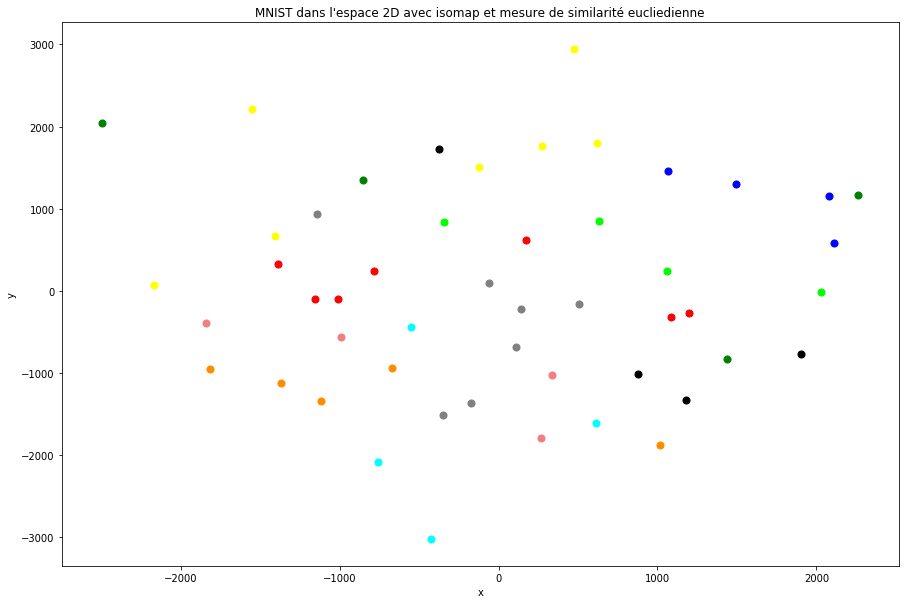

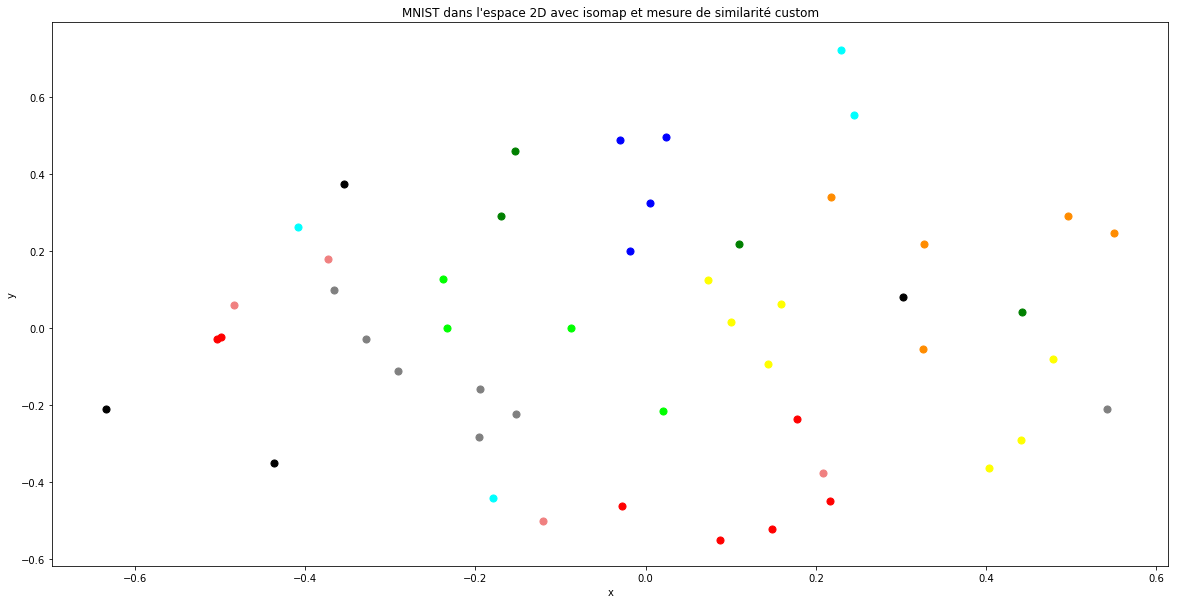

Goodness-of-Fit for ISOMAP with eucliedian distance:       0.22253072332905618
Goodness-of-Fit for ISOMAP with custom similarity mesure:  0.20614732343288975

Best goodness-of-Fit:  ISOMAP with custom similarity mesure


In [14]:
import numpy as np
from sklearn.manifold import MDS

# inf est fixé à 999999999, car math.inf provoque des overflow dans les calculs matriciels plus bas.
inf = 999999999

# Hyperparamètres choisis par l'utilisateur, représentant le rayon max de la distance
rayon_eucliedian = 0.90*np.max(euclidean_distance_matrix)
rayon_custom = 0.90*np.max(custom_distance_matrix)

def isomap_ray(distance_matrix, ray):
    
    new_distance_matrix = np.zeros(distance_matrix.shape)
    
    for i in range(distance_matrix.shape[0]):
        for j in range(distance_matrix.shape[1]):
            if distance_matrix[i][j] > ray:
                new_distance_matrix[i][j] = inf
            else:
                new_distance_matrix[i][j] = distance_matrix[i][j]
        
    return new_distance_matrix
  
# La base de l'algorythme de floyd_warshall provient de mosco (https://gist.github.com/mosco/11178777). L'algorythme
# a été adapté par notre équipe afin qu'il fonctionne avec le contexte du problème demandé
def floyd_warshall(adjacency_matrix): 
    
    mat = np.asarray(adjacency_matrix)
    n = mat.shape[0]

    for k in range(n):
        for i in range(n):
            mat[i,:] = np.minimum(mat[i,:], mat[i,k] + mat[k,:]) 
            
    return mat

isomap_eucl_dissimilarity_matrix = floyd_warshall((isomap_ray(euclidean_distance_matrix, rayon_eucliedian)).copy())
isomap_custom_dissimilarity_matrix = floyd_warshall((isomap_ray(custom_distance_matrix, rayon_custom)).copy())

isomap_pcoa_custom = MDS(n_components=2, dissimilarity='precomputed')
eucl_pcoa_custom = MDS(n_components=2, dissimilarity='precomputed')

isomap_custom_transformed = isomap_pcoa_custom.fit_transform(isomap_custom_dissimilarity_matrix)
eucl_custom_transformed = eucl_pcoa_custom.fit_transform(isomap_eucl_dissimilarity_matrix)

print('Légende')
for i in range(0, len(colors)) :
    print(i, ' : ', colors[i])

plt.figure(figsize=(15,10))
plot_graph_by_labels(eucl_custom_transformed, training_targets, "MNIST dans l\'espace 2D avec isomap et mesure de similarité eucliedienne",colors)

plt.figure(figsize=(20,10))
plot_graph_by_labels(isomap_custom_transformed, training_targets, "MNIST dans l\'espace 2D avec isomap et mesure de similarité custom",colors)

# Mesures de performance utilisée :  
# Nous utilisons la racine de l'erreur de moindre carrée (différence entre la distance de la matrice de dissimilarité et de la distance 
# prédite par le modèle MDS, divisée par la somme au carrée des distances de la matrice de dissimilarité)
# Cette valeur représente le stress, qui permet de quantifer si le modèle fitent avec les données. 
# Plus la valeur est proche de 0, plus le modèle représente les données.

# Pour plus d'information, voir le Chaptitre 435 de Multidimensional Scaling, page 435-3
# https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Multidimensional_Scaling.pdf
goodness_isomap_eucl = np.sqrt(eucl_pcoa_custom.stress_/np.square(isomap_eucl_dissimilarity_matrix).sum())
goodness_isomap_custom = np.sqrt(isomap_pcoa_custom.stress_/np.square(isomap_custom_dissimilarity_matrix).sum())
print("Goodness-of-Fit for ISOMAP with eucliedian distance:      ", goodness_isomap_eucl)
print("Goodness-of-Fit for ISOMAP with custom similarity mesure: ", goodness_isomap_custom)

print("\nBest goodness-of-Fit: ", "ISOMAP with eucliedian distance" if min(goodness_isomap_eucl, goodness_isomap_custom) == goodness_isomap_eucl else "ISOMAP with custom similarity mesure")


## K Nearest Neighbors Algorithm

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import BallTree
from sklearn.metrics import accuracy_score

neighbourinos = 5

KNN_euclid = KNeighborsClassifier(n_neighbors=neighbourinos,  metric='euclidean')
KNN_custom = KNeighborsClassifier(n_neighbors=neighbourinos, algorithm='ball_tree', metric=custom_similarity_measure)

KNN_euclid.fit(training_inputs, training_targets)
KNN_custom.fit(training_inputs, training_targets)

score_euclid = accuracy_score(KNN_euclid.predict(test_inputs), test_targets)
score_custom = accuracy_score(KNN_custom.predict(test_inputs), test_targets)

print("Training dataset size:", TRAINING_SIZE)
print("Neighbours taken into account:", neighbourinos)
print("Euclidean score:", score_euclid)
print("Custom score:", score_custom)

Training dataset size: 50
Neighbours taken into account: 5
Euclidean score: 0.6
Custom score: 0.6
